# YouTube API

# * Team, there is so much more analysis we can do! 
* using subscriber count, viewcount and number of video counts published per channel maybe see if we can make predictions


In [77]:
# Dependencies
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 
import os
import json
import re  
import wordcloud
import requests
import pandas as pd
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import functools as ft
import seaborn as sns
from scipy.stats import logistic
import calendar
import random
from scipy import stats
from config import api_key
import googleapiclient.errors
import matplotlib as mpl
from cycler import cycler
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import googleapiclient.discovery
from youtube_api import YoutubeDataApi
from googleapiclient.discovery import build

# Most watched videos on youtube in 2019:
* Top50 by viewcount in 2019 March through October
* Does number of videos posted per channel attracts more viewers? 
* What were most watched videos in 2019 vs same months in 2020?



In [78]:
#lookthrough youtube api and get top 50 relevant videos published between 3/15/2020 through 10/15/2020
youtube = build("youtube", "v3", developerKey=api_key)
#set api_run_stop False to call the API/ True to skip the API
api_run_stop = True   
if not api_run_stop:
    top50 = youtube.search().list(part=["snippet", "id"],
                                           type="video", 
                                           publishedAfter="2019-03-15T00:00:00Z", 
                                           publishedBefore="2019-10-15T00:00:00Z",
                                           videoDuration="any", 
                                           order="viewCount", 
                                           maxResults=50)
    top50= top50.execute()
#df_top50 is stored in SEARCH_DATA.json so no need to run the api everytime (solves the issue of running out of search quata)
    df_top50 = pd.DataFrame(top50['items'])
    df_top50.to_json('SEARCH_DATA.json')
#print(json.dumps(top50, indent=4, sort_keys=True))

# Data Cleaning:
* Create dataframs 
* Rename and rearrange for better readablility
* Drop irrelevant columns

In [47]:
#df_video_ids, unpacks the dictionary stored in "id" and creats a data frame
df_video_ids = pd.json_normalize(df_top50['id'])

#df_snippets, unpacks the dictionary stored in "snippet" and creats a data frame
df_snippets = pd.json_normalize(df_top50['snippet']) 

#df_top50_merge, merges the above two data frames into one
df_top50_merge = pd.merge(df_video_ids , df_snippets, left_index=True, right_index=True)

#request, gets the 'videoId' and statistics from video api
videos = youtube.videos().list(part='id,statistics,snippet',id=list(df_top50_merge['videoId']), maxResults=50).execute() # json
#df_stat, creats a dataframe for items in response
videos_df = pd.DataFrame(videos['items']) # stat colum is list of dicts

#df_stat_clean, unpacks the dictionary stored in "statistics" and creats a data frame
videos_stat = pd.json_normalize(videos_df['statistics']) 

#df_stat_merge, merges the above two data frames into one (df_top50_merge & df_stat_clean) 
videos_merge = pd.merge(df_top50_merge, videos_stat, left_index=True, right_index=True)

#df_final, drops irrelevant columns and make the data frame cleaner
df_clean = videos_merge.drop(columns=['kind', 'liveBroadcastContent', 
                                       'publishTime', 'thumbnails.default.url', 
                                       'thumbnails.medium.width', 'thumbnails.medium.height', 
                                       'thumbnails.high.url', 'thumbnails.high.width', 'thumbnails.high.height',
                                       'thumbnails.default.width', 'thumbnails.default.height', 'thumbnails.medium.url',
                                       'favoriteCount'])

In [48]:
channels=youtube.channels().list(part='statistics',id=list(df_clean['channelId']), maxResults=50).execute()

#channels_df, creats a dataFrame of channels
channels_df = pd.DataFrame(channels['items'])

#channels_stat, unpack "statistics" into a dataFrame
channels_stat = pd.json_normalize(channels_df['statistics'])

#channels_merge, merge new stat with above df
channels_merge = pd.merge(df_clean, channels_stat, left_index=True, right_index=True)

#clean_data, rename columns for cleaner look
clean_data = channels_merge.rename(columns={"viewCount_x": "VideoViewCount", "viewCount_y": "channelViewCount", 
                                            "title": "VideoTitle", "commentCount_x": "Vid_commentCount"})
#drop columns for cleaner view
clean_data = clean_data.drop(columns="hiddenSubscriberCount")
#clean_data.head(50)
#qc_stat, displays a dataframe withcleaner order 
clean_data_19= pd.DataFrame(clean_data, columns=["channelTitle", "VideoTitle", "channelViewCount", "subscriberCount", "videoCount", "VideoViewCount", 
                                                  "likeCount", "dislikeCount", "commentCount", "description"])
clean_data_19.head()

,channelTitle,VideoTitle,channelViewCount,subscriberCount,videoCount,VideoViewCount,likeCount,dislikeCount,commentCount,description
0,TV9 Telugu Live,TV9 Telugu LIVE,5432884,NaN,8,404985852,NaN,NaN,0,TV9 Telugu Live is a 24/7 news channel in Andh...
1,TV5 News,TV5 News LIVE | LIVE Updates | AP Politics | B...,6563755,64000,230,70947235,70391,25589,0,"World's first Anti Viral Immunity Booster ""COR..."
2,Video Hub,Bindas Tuition Teacher Se Pyaar | Latest Full ...,16930777,35300,0,63801352,162184,52645,14054,Subscribe my channel likes comments on my vide...
3,Space Videos,Earth Views: Earth From Space Seen From The ISS,189763800,935000,212,35496263,1121768,41861,0,A series of unique and beautiful recorded view...
4,Newsmax TV,LIVE NOW: 2020 Election results on Newsmax TV,8243962,258000,37,15351745,144519,9937,0,"Newsmax TV, America's fastest-growing cable ne..."


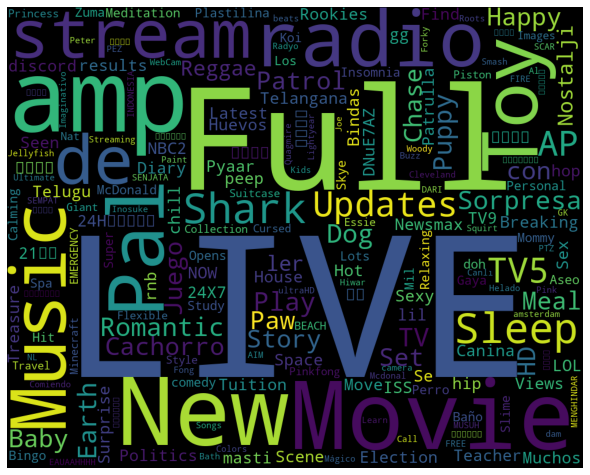

In [79]:
#creating wordcloud
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the file 
for val in clean_data_19["VideoTitle"]: 
      
# type each val to string 
    val = str(val) 
  
# split the value 
    tokens = val.split() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Most watched videos on youtube in 2020:
* Data contains Top50 (03/15/2020 through 10/15/2020)


In [80]:
#lookthrough youtube api and get top 50 relevant videos published between (7/15/2020 through 10/15/2020)

youtube = build("youtube", "v3", developerKey=api_key)
#set api_run_stop False to call the API/ True to skip the API
api_run_stop = True  
if not api_run_stop:
    top50 = youtube.search().list(part=["snippet", "id"],
                                  type="video", 
                                  publishedAfter="2020-03-15T00:00:00Z", 
                                  publishedBefore="2020-10-15T00:00:00Z",
                                  videoDuration="any", 
                                  order="viewCount", 
                                  maxResults=50)
    top50= top50.execute()
#df_top50 is stored in SEARCH_DATA.json so no need to run the api everytime (solves the issue of running out of search quata)
    df_top50 = pd.DataFrame(top50['items'])
    df_top50.to_json('SEARCH_DATA.json')
#print(json.dumps(top50, indent=4, sort_keys=True))

# Data Cleaning:
* Create dataframs 
* Rename and rearrange for better readablility
* Drop irrelevant columns

In [51]:
#df_video_ids, unpacks the dictionary stored in "id" and creats a data frame
df_video_ids = pd.json_normalize(df_top50['id'])

#df_snippets, unpacks the dictionary stored in "snippet" and creats a data frame
df_snippets = pd.json_normalize(df_top50['snippet']) 

#df_top50_merge, merges the above two data frames into one
df_top50_merge = pd.merge(df_video_ids , df_snippets, left_index=True, right_index=True)

#request, gets the 'videoId' and statistics from video api
request = youtube.videos().list(part='id,statistics,snippet',id=list(df_top50_merge['videoId']))
response = request.execute()# json
#df_stat, creats a dataframe for items in response
df_stat = pd.DataFrame(response['items']) # stat colum is list of dicts

#df_stat_clean, unpacks the dictionary stored in "statistics" and creats a data frame
df_stat_clean = pd.json_normalize(df_stat['statistics']) 
#df_stat_merge, merges the above two data frames into one (df_top50_merge & df_stat_clean) 
df_stat_merge = pd.merge(df_top50_merge, df_stat_clean, left_index=True, right_index=True)

#df_final, drops irrelevant columns and make the data frame cleaner
df_final = df_stat_merge.drop(columns=['kind', 'liveBroadcastContent', "channelId", 'publishTime', 'thumbnails.default.url', 'thumbnails.medium.width', 'thumbnails.medium.height', 'thumbnails.high.url', 'thumbnails.high.width', 'thumbnails.high.height', 'thumbnails.default.width', 'thumbnails.default.height', 'thumbnails.medium.url', 'favoriteCount'])

In [52]:
channels=youtube.channels().list(part='statistics',id=list(df_stat_merge['channelId']), maxResults=50).execute()

#channels_df, creats a dataFrame of channels
channels_df = pd.DataFrame(channels['items'])

#channels_stat, unpack "statistics" into a dataFrame
channels_stat = pd.json_normalize(channels_df['statistics'])

#channels_merge, merge new stat with above df
channels_merge = pd.merge(df_final, channels_stat, left_index=True, right_index=True)

#clean_data, rename columns for cleaner look
clean_data = channels_merge.rename(columns={"viewCount_x": "VideoViewCount", "viewCount_y": "channelViewCount", 
                                            "title": "VideoTitle", "commentCount_x": "Vid_commentCount"})
#drop columns for cleaner view
clean_data = clean_data.drop(columns="hiddenSubscriberCount")
#clean_data.head(50)
#qc_stat, displays a dataframe withcleaner order 
clean_data_20 = pd.DataFrame(clean_data, columns=["channelTitle", "VideoTitle", "channelViewCount", "subscriberCount", "videoCount", "VideoViewCount", 
                                                  "likeCount", "dislikeCount", "commentCount", "description"])
clean_data_20.head()
#.set_index(["channelTitle", "VideoTitle"])

,channelTitle,VideoTitle,channelViewCount,subscriberCount,videoCount,VideoViewCount,likeCount,dislikeCount,commentCount,description
0,TV9 Telugu Live,TV9 Telugu LIVE,5432884,NaN,8,404985852,NaN,NaN,0,TV9 Telugu Live is a 24/7 news channel in Andh...
1,TV5 News,TV5 News LIVE | LIVE Updates | AP Politics | B...,27856764,266000,7,70948064,70392,25589,0,"World's first Anti Viral Immunity Booster ""COR..."
2,Video Hub,Bindas Tuition Teacher Se Pyaar | Latest Full ...,131739557,492000,17277,63802671,162184,52645,14054,Subscribe my channel likes comments on my vide...
3,Space Videos,Earth Views: Earth From Space Seen From The ISS,6563755,64000,230,35496263,1121769,41862,0,A series of unique and beautiful recorded view...
4,Newsmax TV,LIVE NOW: 2020 Election results on Newsmax TV,2452243132,3270000,1037,15353298,144520,9937,0,"Newsmax TV, America's fastest-growing cable ne..."


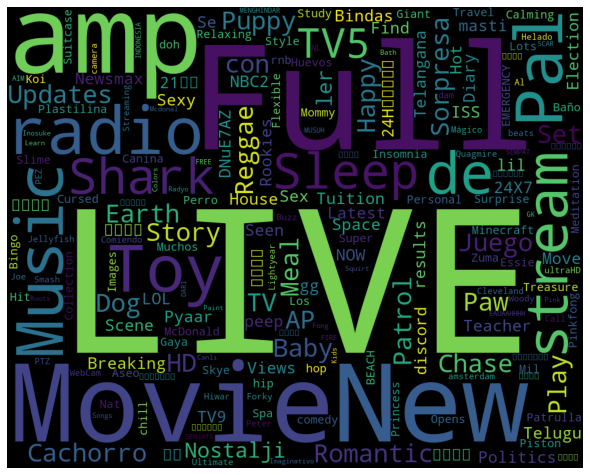

In [53]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the file 
for val in clean_data_20["VideoTitle"]: 
      
# typecaste each val to string 
    val = str(val) 
  
# split the value 
    tokens = val.split()  
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Top 50 Quarantine Challenges:
* During strict lockdown(03/15/2020 through 06/15/2020)
* Does subscription indicate the likelyhood of likes/dislike, and viewCount?

In [81]:
#youtube, looking through youtube api
youtube = build("youtube", "v3", developerKey=api_key)
#use api_run_stop, False calls the API/ True skips the API 
api_run_stop =False
if not api_run_stop:
    top50_qc = youtube.search().list(q="Quarantine Challenge",
                                     part=["snippet", "id"],
                                     type="video",
                                     publishedAfter="2020-03-15T00:00:00Z", 
                                     publishedBefore="2020-06-15T00:00:00Z",
                                     videoDuration="any", 
                                     order="viewCount", 
                                     maxResults=50)
    top50_qc= top50_qc.execute()
    top50_qc_df = pd.DataFrame(top50_qc['items'])
    top50_qc_df.to_json('SEARCH_CACHE.json')
    top50_qc_df=pd.DataFrame(pd.read_json('SEARCH_CACHE.json')) 
#print(json.dumps(top50_qc, indent=4, sort_keys=True))

# Data Cleaning:
* Create dataframs 
* Rename and rearrange for better readablility
* Drop irrelevant columns


In [82]:
#df_video_ids, unpacks the dictionary stored in "id" and creats a data frame
df_video_ids = pd.json_normalize(top50_qc_df['id'])

#df_snippets, unpacks the dictionary stored in "snippet" and creats a data frame
df_snippets = pd.json_normalize(top50_qc_df['snippet'])

#df_top50_merge, merges the above two data frames into one
df_top50_merge = pd.merge(df_video_ids , df_snippets, left_index=True, right_index=True)

#request, gets the 'videoId' and statistics from video api
request = youtube.videos().list(part='id,statistics,snippet',id=list(df_top50_merge['videoId']))
response = request.execute()# json

df_stat = pd.DataFrame(response['items']) # response['items'] list of dicts

#df_stat_clean, unpacks the dictionary stored in "statistics" and creats a data frame
df_stat_clean = pd.json_normalize(df_stat['statistics']) 

# df_stat_merge, merges df_stat_clean with df_top50_merge
df_stat_merge = pd.merge(df_top50_merge, df_stat_clean, left_index=True, right_index=True)
#qc_df_final, drop irrelevant columns to present cleaner dataframe
qc_df_final = df_stat_merge.drop(columns=['kind', 'liveBroadcastContent', 
                                          'publishTime', 'thumbnails.default.url', 'thumbnails.medium.width', 
                                          'thumbnails.medium.height', 'thumbnails.high.url', 'thumbnails.high.width', 
                                          'thumbnails.high.height', 'thumbnails.default.width', 'thumbnails.default.height', 
                                          'thumbnails.medium.url'])

qc_df_final.head()

#channels, gets the 'channelId' and statistics from youtube channels api
channels=youtube.channels().list(part='statistics',id=list(qc_df_final['channelId']), maxResults=50).execute()

#channels_df, creats a dataFrame of channels
channels_df = pd.DataFrame(channels['items'])

#channels_stat, unpack "statistics" into a dataFrame
channels_stat = pd.json_normalize(channels_df['statistics'])

#channels_merge, merge new stat with above df
channels_merge = pd.merge(qc_df_final, channels_stat, left_index=True, right_index=True)

#clean_data, rename columns for cleaner look
clean_data = channels_merge.rename(columns={"viewCount_x": "VideoViewCount", "viewCount_y": "channelViewCount", 
                                            "title": "VideoTitle", "commentCount_x": "Vid_commentCount"})
#drop columns for cleaner view
clean_data = clean_data.drop(columns=["hiddenSubscriberCount", "favoriteCount"])
#clean_data.head(50)
#clean_data_qc, displays a dataframe withcleaner order 
clean_data_qc = pd.DataFrame(clean_data, columns=["channelTitle", "VideoTitle", "channelViewCount", "subscriberCount", "videoCount", "VideoViewCount", 
                                                  "likeCount", "dislikeCount", "commentCount", "description"])
clean_data_qc.head()
#.set_index(["channelTitle", "VideoTitle"])

,channelTitle,VideoTitle,channelViewCount,subscriberCount,videoCount,VideoViewCount,likeCount,dislikeCount,commentCount,description
0,Diamond Platnumz,"Quarantine - Wasafi Feat Diamond Platnumz, Ray...",21408946,261000,56,13228993,135218,12100,14389,Do You Think Your Quarantine Moves Are Better ...
1,Chloe Ting,Get SNATCHED during Quarantine | Before After ...,125890199,1280000,260,5556457,202049,1292,8227,Here are some before after transformation jour...
2,Little Big Toys,Bug&#39;s Quarantine TikTok Videos,2791074,11800,15,4301661,50259,5953,NaN,Bug have been spending a lot of time doing tik...
3,Trinity and Beyond,Hello Neighbor Steals Our Quarantine Games!!! ...,652022471,1950000,782,4002580,41720,3786,NaN,Hello Neighbor in Real Life Steals Our Play at...
4,SNOWTHAPRODUCT,Snow Tha Product - NoWhere To Go (QUARANTINE L...,2420846223,4530000,17651,2721720,82316,1638,10731,Since everyone is quarantined in the house bec...


C:\Users\redea\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 56613 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 56887 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\redea\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarn

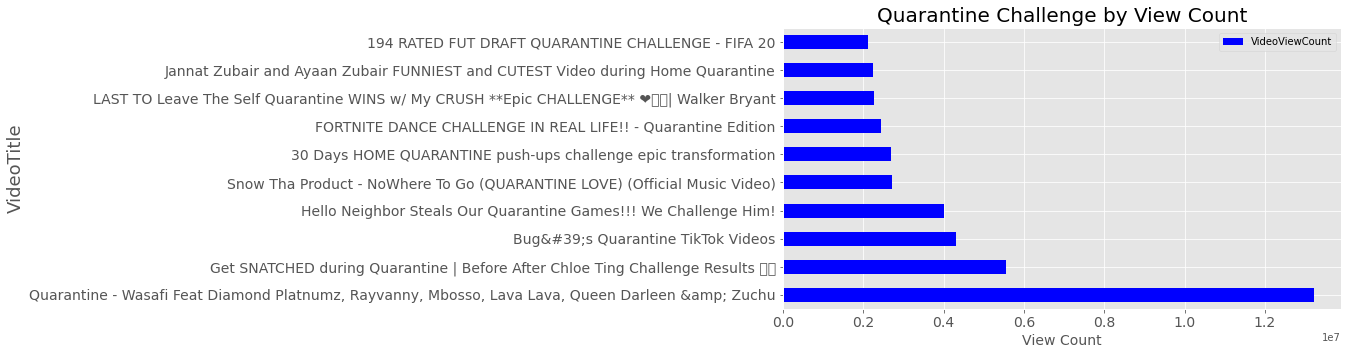

In [83]:
top_viewed = clean_data_qc.head(10)
top_viewed.sort_values('VideoViewCount', ascending = False)
# Top quarantine challenge videos by view count
top_viewed.set_index('VideoTitle', inplace=True)
top_viewed.VideoViewCount = top_viewed.VideoViewCount.astype('int64')
plot_pandas = top_viewed.plot.barh(figsize=(10,5), color='blue',fontsize = 14)
plt.xlabel('View Count',fontsize = 14)
plt.ylabel('VideoTitle',fontsize = 18)
plt.title('Quarantine Challenge by View Count',fontsize = 20)
#plt.savefig('./output/top_viewed.png', bbox_inches='tight')
plt.show()

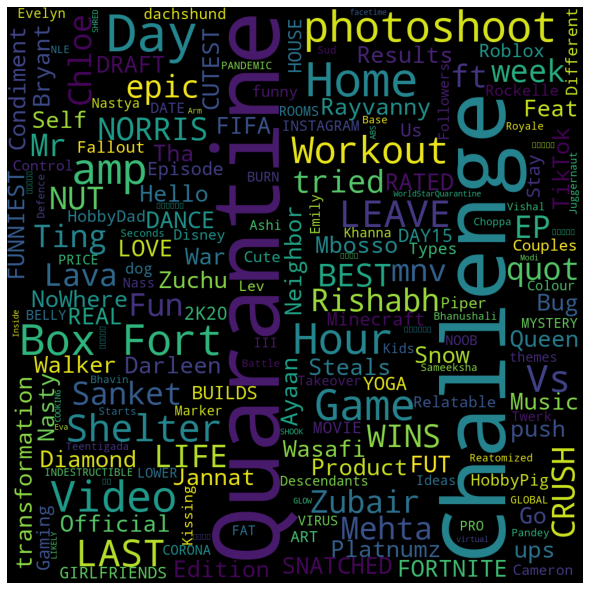

In [84]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the file 
for val in clean_data_qc["VideoTitle"]: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # to convert each token into lowercase 
    #for i in range(len(tokens)): 
        #tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
#export clean data
#df.to_csv("youtube_data.csv", index=False, header=True)